# goal of attempt: use one speech indicator function only. 

In [20]:
from scipy.io import wavfile 
capstone_dir = "/Users/ninismacbook/other_docs/Y4S1+S2/capstone" 
import matplotlib.pyplot as plt; import numpy as np; import pandas as pd ; import librosa
import librosa.display # Must have
from dtw import dtw;
import math

In [21]:
def downsample(query, ratio):
    
    # Scale the amplitudes by dividing each amplitude over the largest amplitude magnitude
    max_m = np.abs(max(query))
    res = []
    for i in range(int(len(query) // ratio)):
        if int(i*ratio) < len(query):
            res.append(query[int(i*ratio)]/max_m)
    return res

# Everything together - 13 MFCCs

In [22]:
def normalize(mfcc):
    
    matrix = np.zeros((mfcc.shape))
    
    for i in range(mfcc.shape[0]):
        array = mfcc[i, :]
        mean = np.mean(array)
        sd = np.std(array)        
        for j in range(mfcc.shape[1]):

            new_val = (mfcc[i, j]-mean)/sd
            matrix[i, j] = new_val
    return matrix

# print(normalize(np.array([[3, 2, 1], [3, 2, 3]])))

In [23]:
# deviation function
def deviation(rho, theta):
    dev = 0
    if rho >= theta and rho <= math.pi/2:
        dev = (rho-theta)/(math.pi/2-theta)
    else:
        dev = (theta - rho)/theta
    return dev

In [24]:
def remove_short_pauses(speech_array, min_pause_len_s, mfcc_len_s): # filter out pauses shorter than min_pause_len_s in speech array
    
    sp_transitions = []     
    for s in range(len(speech_array)-1):
        if s > 0 and s < len(speech_array):
            if speech_array[s] == 0 and speech_array[s+1] == 1:
                sp_transitions.append(s)
            if speech_array[s] == 1 and speech_array[s+1] == 0:
                sp_transitions.append(s)
    
    for t in range(len(sp_transitions)-1):
        if (sp_transitions[t+1] - sp_transitions[t])*mfcc_len_s < min_pause_len_s:
            speech_array[sp_transitions[t]:sp_transitions[t+1]] = [1]*(sp_transitions[t+1]-sp_transitions[t])
            
    return speech_array

In [25]:
def speech(smooth_query, original_query, seg1_1, seg1_2, samplerate, frame_per_window, **kwargs):

    input_min_amp = kwargs.get('input_min_amp', None)
    input_min_pause = kwargs.get('input_min_pause', None)    # unit = ms
    
    if input_min_amp == None:
        abs_q = np.abs(original_query[int(samplerate*0.5): int(samplerate*0.5 + frame_per_window)])    
        default_min_amp = np.max(abs_q)
        print('Default amplitude threshold: ', default_min_amp)
        min_amp = default_min_amp
    else:
        min_amp = input_min_amp
    
    indices = []
    max_am = max(np.abs(original_query))    
    result = []                
    result.append(0) # the first frame is always pause
    
    for i in range(1, len(smooth_query)):    

        # Since we scaled the amplitudes, we need to multiply the smoothened amplitude value by the normalization constant
        if np.abs(smooth_query[i]) > min_amp:
            
            if result[-1] == 0: # if previous frame is pause, this index marks start of speech
                indices.append(i)
            result.append(1)
            
        else:
            if result[-1] == 1: # if previous frame is speech, this index marks end of speech
                indices.append(i)
            result.append(0)
    
    min_pause_len = input_min_pause * samplerate /1000

    # filter out pauses whose length is shorter than input_min_pause
    for p in range(1, len(indices)-1, 2):
        if indices[p+1] - indices[p] < min_pause_len:

            # Update result: change the pauses that are too short to speech
            result[indices[p] : indices[p+1]] = [1] * (indices[p+1] - indices[p])
            
            # Update the indices to -1, and remove all -1 index in the end
            indices[p+1] = -1
            indices[p] = -1

    indices = [seg for seg in indices if seg != -1]            

    return result, min_amp

In [26]:
def stretch(alignment, seg_index_x, seg_index_y, common_seg_dict, path_indices, alpha):
    
    theta = math.atan(max(alignment.index2)/max(alignment.index1))  # angle of diagonal = length of y axis over length of x axis
    
    for s in range(0, len(path_indices)-1):     # calculate stretch in each common segment

        xs = alignment.index1[path_indices[s]:path_indices[s+1]]
        ys = alignment.index2[path_indices[s]:path_indices[s+1]]

        stretch = 0
        arclen = 0            

        for i in range(0, len(xs)-1):
            
            if i % alpha == 0:
                if xs[i+1]-xs[i] == 0:
                    rho_i = math.pi/2
                else:
                    rho_i = math.atan((ys[i+1]-ys[i]) / (xs[i+1]-xs[i]))

                dev_rho_i = deviation(rho_i, theta)
                stretch = stretch + dev_rho_i*math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
                
            arclen = arclen + math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
        
        if arclen == 0:
            segment_stretch = 0
        else:
            segment_stretch = stretch/arclen
            
        common_seg_dict[s+1].append(segment_stretch) # the index is s+1 because common_seg_dict starts with 1

In [30]:
def output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, *args, **kwargs):
    
    threshold1 = kwargs.get('threshold1', None)
    threshold2 = kwargs.get('threshold2', None)
    timelst1 = kwargs.get('timelst1', None)
    timelst2 = kwargs.get('timelst2', None)
    num_of_mfcc = kwargs.get('num_of_mfcc', 13)
    input_min_pause = kwargs.get('input_min_pause', None)


    x, sr1 = librosa.load(capstone_dir + "/py_converted/" + file1, sr=None)
    y, sr2 = librosa.load(capstone_dir + "/py_converted/" + file2, sr=None)

    fragment_x = x[int(sr1*seg1_1): int(sr1*seg1_2)]
    fragment_y = y[int(sr2*seg2_1): int(sr2*seg2_2)]

    # number of mfcc frames = audio length * samplerate / hop length (default = 512)
    # set hop_length = __ s
    hop_len_in_s = 0.005

    mfcc1 = librosa.feature.mfcc(fragment_x, sr1, n_mfcc=num_of_mfcc, hop_length=int(hop_len_in_s*sr1))
    mfcc2 = librosa.feature.mfcc(fragment_y, sr2, n_mfcc=num_of_mfcc, hop_length=int(hop_len_in_s*sr2)) 

    # normalize each mfcc
    mfcc1_normal = normalize(mfcc1)
    mfcc2_normal = normalize(mfcc2)
    
    dtw_input1 = mfcc1_normal.T
    dtw_input2 = mfcc2_normal.T
    
    alignment = dtw(dtw_input1, dtw_input2, keep_internals=True)
    alignment.plot('threeway')
    
    if timelst1 and timelst2:
        plt.figure(figsize=(15, 3))
        plt.plot(alignment.index1, alignment.index2)
        
        time1_2 = (np.array(timelst1) - seg1_1)*sr1/int(hop_len_in_s*sr1)
        time2_2 = (np.array(timelst2) - seg2_1)*sr2/int(hop_len_in_s*sr2)

        colors = ['red', 'g', 'b', 'm', 'brown', '#d89743', 'grey', 'c', 'orange', 'g', 'b', 'm', 'red']

        for i in range(len(time1_2)):
            x_axis, y_axis = time1_2[i], time2_2[i]
            plt.axvline(x_axis, color = colors[i])
            plt.hlines(y_axis, 0, x_axis+10, color = colors[i]) 
            
    time1 = np.linspace(seg1_1, seg1_2, num = mfcc1.shape[1]) 

    smooth_x = [] # Store smoothened sample array
    smooth_y = [] # Store smoothened ref array
    
    # Rolling average on original_x and original_y. Store results in smooth_x, smooth_y
    
    frame_per_window = sr1 * window_len/1000 # Do smoothening on the query and ref
    min_pause_len_s = input_min_pause /1000
    mfcc_len_s = (time1[-1]-time1[0])/mfcc1.shape[1] # duration of each mfcc = audio length / number of mfcc    
    
    
    for i in range(len(fragment_x)):
        if i < frame_per_window/2:
            i1 = 0 ; i2 = i + int(frame_per_window/2)            
        elif i > (len(fragment_x) - frame_per_window/2):
            i1 = i - frame_per_window/2 ; i2 = len(fragment_x)
        else:
            i1 = i-frame_per_window/2 ; i2 = i+frame_per_window/2
        num = np.mean(np.abs(fragment_x[int(i1) : int(i2)]))
        smooth_x.append(num)
        
    for i in range(len(fragment_y)):
        if i < frame_per_window/2:
            i1 = 0 ; i2 = i + int(frame_per_window/2)            
        elif i > (len(fragment_y) - frame_per_window/2):
            i1 = i - frame_per_window/2 ; i2 = len(fragment_y)
        else:
            i1 = i-frame_per_window/2 ; i2 = i+frame_per_window/2
        num = np.mean(np.abs(fragment_y[int(i1) : int(i2)]))
        smooth_y.append(num)


    speech_x, min_amp_x = speech(smooth_x, x, seg1_1, seg1_2, sr1, frame_per_window, 
                     input_min_amp = threshold1,
                     input_min_pause = input_min_pause)

    speech_y, min_amp_y = speech(smooth_y, y, seg2_1, seg2_2, sr2, frame_per_window, 
                   input_min_amp = threshold2, 
                   input_min_pause = input_min_pause)     
    
    speech_x = remove_short_pauses(speech_x, min_pause_len_s, mfcc_len_s)
    speech_y = remove_short_pauses(speech_y, min_pause_len_s, mfcc_len_s)
    
    xs = alignment.index1
    ys = alignment.index2 
        
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
    fig.set_size_inches(20, 12)

    time = np.linspace(seg1_1, seg1_2, num = len(fragment_x))
    xticks = np.linspace(seg1_1, seg1_2, num = 20)
    
    ax1.plot(time, fragment_x)
    ax1.set_xticks(xticks) 
    if timelst1:
        for t in timelst1:
                ax1.axvline(t, color = 'black', ymin=0, ymax=1, linewidth=2)        
    
    ax2.plot(time, smooth_x)
    ax2.set_xticks(xticks)
    ax2.axhline(y = min_amp_x)          
    ax3.plot(time, speech_x)
    ax3.set_xticks(xticks)


    time = np.linspace(seg2_1, seg2_2, num = len(fragment_y))
    xticks = np.linspace(seg2_1, seg2_2, num = 20)
    
    ax4.plot(time, fragment_y)
    if timelst2:
            for t in timelst2:
                    ax4.axvline(t, color = 'black', ymin=0, ymax=1, linewidth=2)       
    ax4.set_xticks(xticks) 
    
    time2 = np.linspace(seg2_1, seg2_2, num = mfcc2.shape[1])
    ax5.plot(time, smooth_y)
    ax5.set_xticks(xticks)
    ax5.axhline(y = min_amp_y)     
  

    seg_index_x, seg_index_y, common_seg_dict, path_indices = return_common_seg(alignment, sr1,
                                                                                speech_x, speech_y, 
                                                                                time1, time2, 
                                                                                min_pause_len_s, mfcc_len_s)
    
    color_counter = 0
    for seg in list(common_seg_dict.values()):

        if color_counter % 2 == 0:
            c = 'red'
        else:
            c = 'green'

        ax3.axvline(seg[1], color = c, ymin=0, ymax=1, linewidth=4)   
        ax5.axvline(seg[2], color = c, ymin=0, ymax=1, linewidth=4)    
                        
        color_counter = color_counter + 1
  
    common_seg_dict.pop(len(common_seg_dict)) # remove the last pause segment
    alpha = kwargs.get('alpha', mfcc_len_s*1000)    
    stretch(alignment, seg_index_x, seg_index_y, common_seg_dict, path_indices, int(alpha/(mfcc_len_s*1000)))
    
    
    
    df = pd.DataFrame(common_seg_dict)
    df.index = ['seg', 'start in voice 1', 'start in voice 2', 'stretch']
    print(df)
    print('\nDTW distance = ', alignment.normalizedDistance)

In [31]:
num_of_mfcc = 10;
window_len = 30

In [32]:
def return_common_seg(alignment, sr1, speech_x, speech_y, time1, time2, min_pause_len_s, mfcc_len_s):
    
    xs = alignment.index1
    ys = alignment.index2
    
    # For 1 point in the warping path x, y
    # xs[i] = index of the point in the original query that dtw uses to align x
    # ys[i] = index of the point in the original reference query that dtw uses to align y                      
    # length of path = len(path[0]) = len(path[1])

    common_seg = {} # store the list of speech and pause segments
    common_seg_dict = {}
    path_indices = []

    seg_index_x = []
    seg_index_y = []
    
    len_x = len(speech_x)
    len_y = len(speech_y)    
    
    seg_index = 0

    
    for i in range(len(speech_x)-1):  # get segments in y based on alignment curve
        
        if speech_x[i] != speech_x[i+1]:
            
            if speech_x[i] == 0:                #speech segment starts
                seg = "speech"

            if speech_x[i] == 1:                # pause segment starts
                seg = "pause"

            seg_index_x = int(i/len_x*max(alignment.index1))       #i/len_x = the proportion in speech_x. max(alignment.index1) gives the total number of mfcc in x
            timestamps_x = seg_index_x*mfcc_len_s+time1[0]

            y_index = np.where(alignment.index1 == seg_index_x)    
            seg_index_y = alignment.index2[y_index][0]
        
            timestamps_y = seg_index_y*mfcc_len_s+time2[0]
            common_seg_dict[seg_index+1] = [seg, timestamps_x, timestamps_y]
            
            seg_index = seg_index + 1  
            path_indices.append(y_index[0][0])
    
    path_indices = np.squeeze(path_indices)
    
    return seg_index_x, seg_index_y, common_seg_dict, path_indices

# We have really enjoyed the project

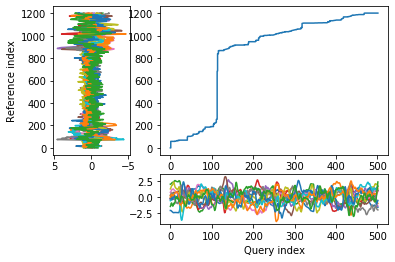

                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1    1.6245   1.73406   1.76892   1.96813   2.13745   2.74004   
start in voice 2   2.34363   2.51295   2.53287   2.92131   6.32271   7.01494   
stretch           0.982641  0.506543  0.941434  0.992045  0.935261  0.736215   

                        7         8         9         10        11  
seg                 speech     pause    speech     pause    speech  
start in voice 1   2.80478   3.09861   3.24801   3.30777   3.44223  
start in voice 2   7.08466   7.54283   7.54781   7.55279   7.64741  
stretch           0.885335  0.967887  0.917245  0.934469  0.789823  

DTW distance =  2.5970962562826645


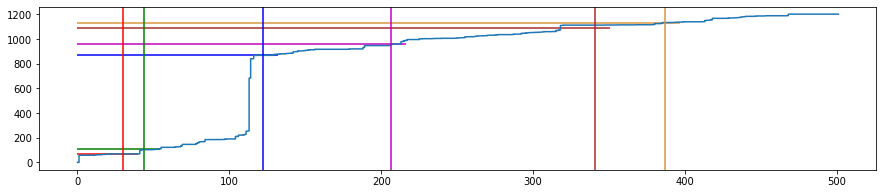

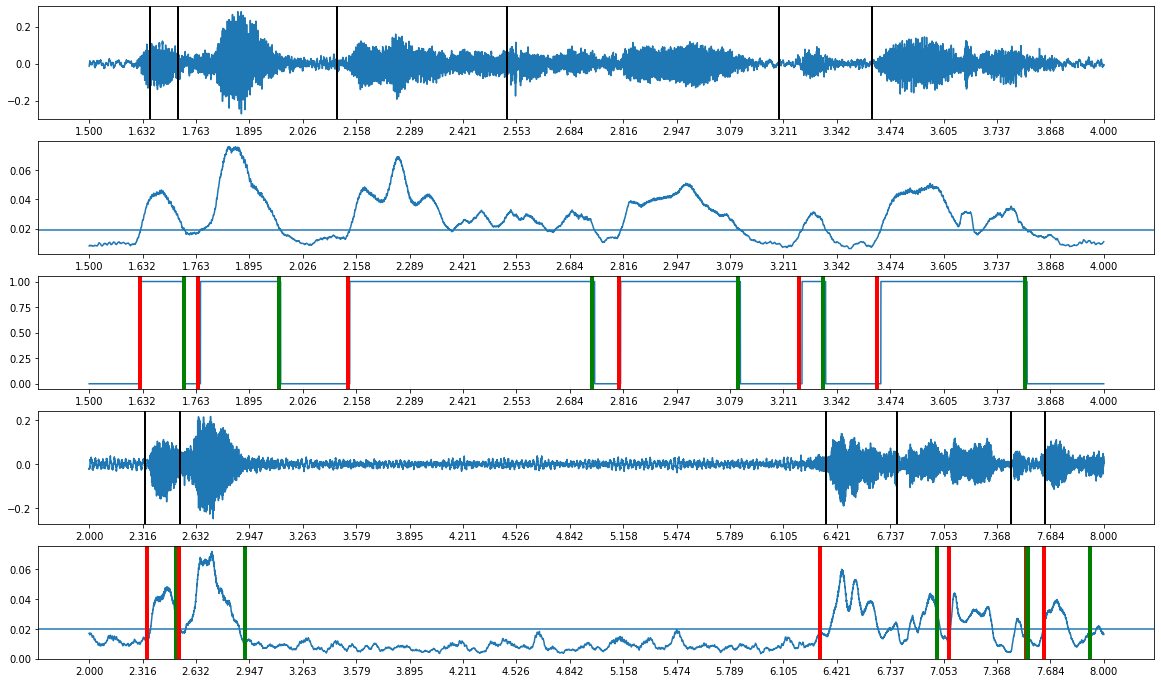

In [33]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-pause2.wav", 2, 8

timelst1 = [1.65, 1.72, 2.11, 2.53, 3.2, 3.43]
timelst2 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.019, threshold2=0.02,
      timelst1=timelst1, timelst2 = timelst2)

In [ ]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-pause2.wav", 2, 8.5

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.019, threshold2=0.01,
      timelst1=timelst1, timelst2 = timelst2, alpha = 20)

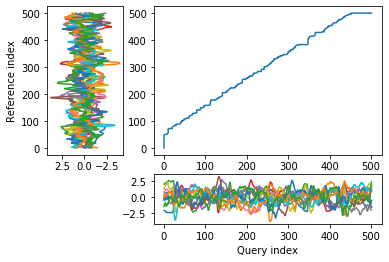

                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   1.50059   1.50109   1.50125   1.50215   1.50293   1.50549   
start in voice 2   1.50188   1.50234   1.50249   1.50342   1.50415   1.50676   
stretch           0.133386  0.177894  0.123048  0.145969  0.117896  0.134618   

                       7         8         9         10        11  
seg                speech     pause    speech     pause    speech  
start in voice 1  1.50596    1.5073     1.508   1.50828   1.50893  
start in voice 2   1.5073   1.50866   1.50941    1.5095   1.51014  
stretch           0.15054  0.151298  0.163363  0.119252  0.138433  

DTW distance =  1.9937129492804249


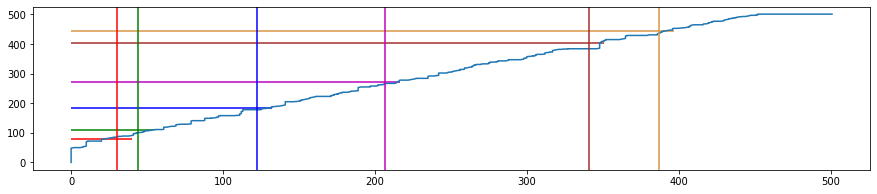

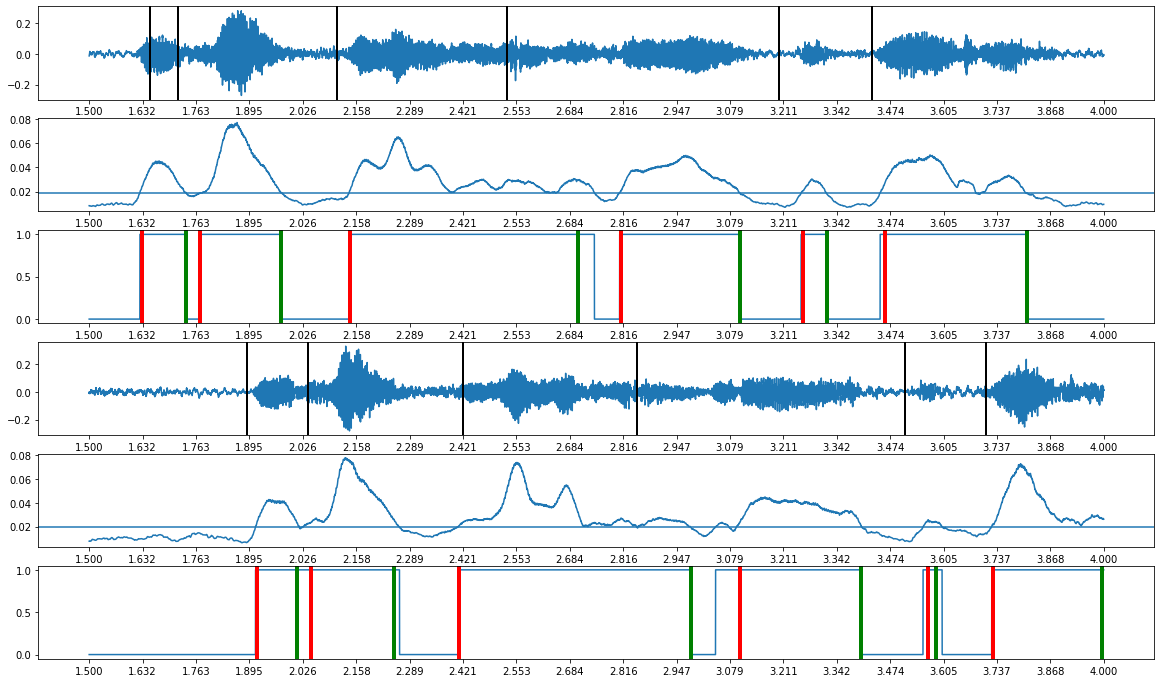

In [98]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-normal2.wav", 1.5, 4

timelst1 = [1.65, 1.72, 2.11, 2.53, 3.2, 3.43]
timelst2 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1=0.019, threshold2=0.02,
      timelst1=timelst1, timelst2 = timelst2, alpha=30)
# unit for input_min_pause and alpha = ms 

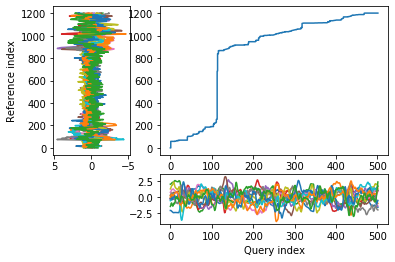

                        1         2         3        4         5         6   \
seg                 speech     pause    speech    pause    speech     pause   
start in voice 1   1.50093   1.50109   1.50125   1.5019   1.50304   1.50429   
start in voice 2   2.00166   2.00234   2.00261  2.00406   2.01995   2.02127   
stretch           0.154447  0.199057  0.151538  0.16495  0.163684  0.182387   

                       7         8         9        10       11        12  \
seg                speech     pause    speech    pause   speech     pause   
start in voice 1  1.50467   1.50469   1.50483  1.50567  1.50596   1.50719   
start in voice 2  2.02154   2.02177   2.02209  2.02286   2.0232   2.02433   
stretch               0.2  0.210526  0.159878  0.13072  0.14704  0.185185   

                        13        14        15  
seg                 speech     pause    speech  
start in voice 1   1.50721   1.50721   1.50889  
start in voice 2   2.02494   2.02512   2.02571  
stretch           0.28

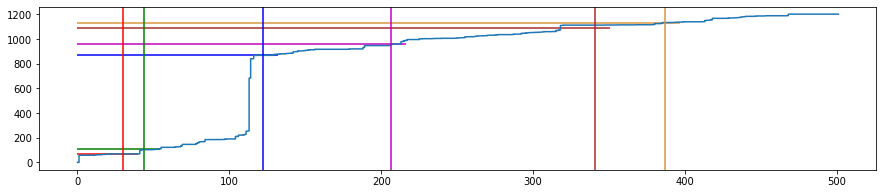

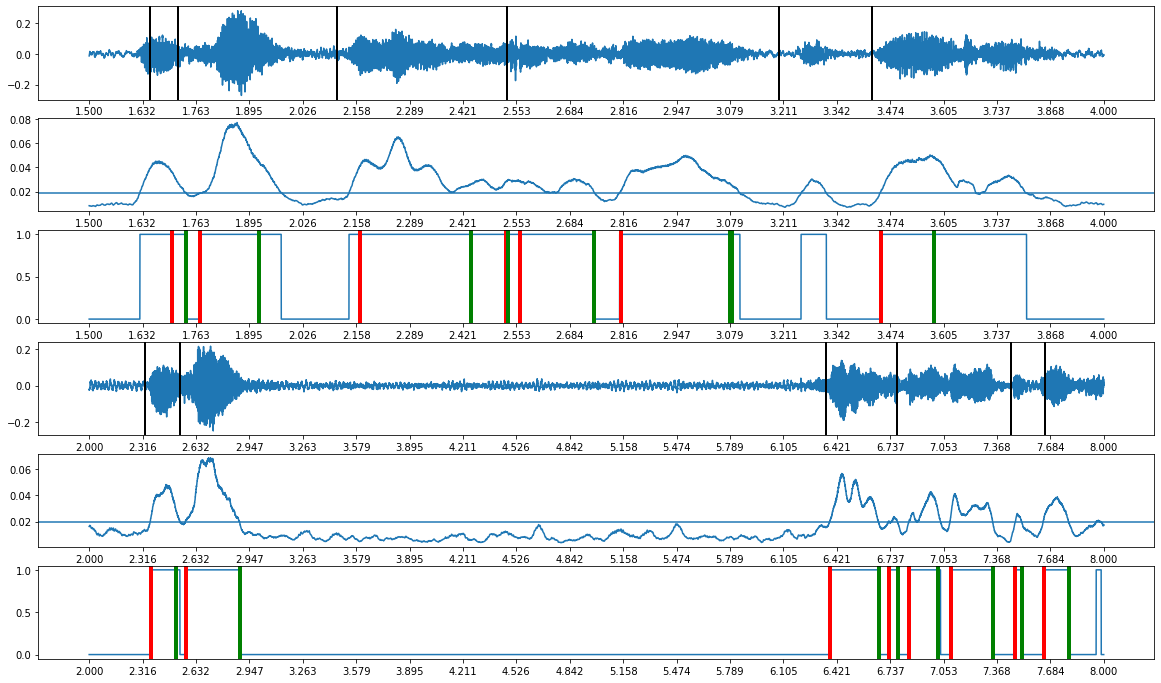

In [100]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-pause2.wav", 2, 8

timelst1 = [1.65, 1.72, 2.11, 2.53, 3.2, 3.43]
timelst2 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.019, threshold2=0.02,
      timelst1=timelst1, timelst2 = timelst2, alpha = 30)

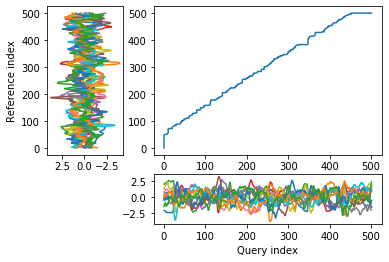

                        1        2         3         4         5        6   \
seg                 speech    pause    speech     pause    speech    pause   
start in voice 1   1.50059  1.50107   1.50134   1.50213   1.50295   1.5051   
start in voice 2   1.50188  1.50231   1.50252    1.5034   1.50417  1.50637   
stretch           0.142568  0.16445  0.148938  0.155074  0.123469  0.11327   

                        7         8          9         10        11       12  \
seg                 speech     pause     speech     pause    speech    pause   
start in voice 1   1.50528   1.50549    1.50599   1.50728   1.50803  1.50825   
start in voice 2   1.50644   1.50671     1.5073   1.50866   1.50941  1.50948   
stretch           0.159334  0.123285  0.0962741  0.162641  0.203491  0.10881   

                         13  
seg                  speech  
start in voice 1    1.50898  
start in voice 2    1.51016  
stretch           0.0958264  

DTW distance =  1.9937129492804249


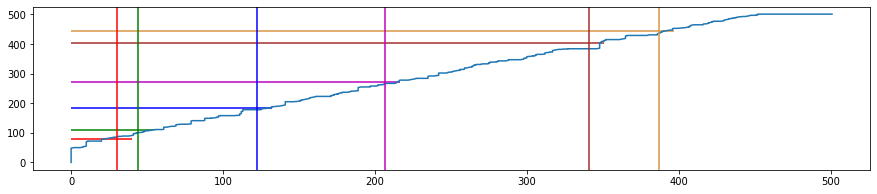

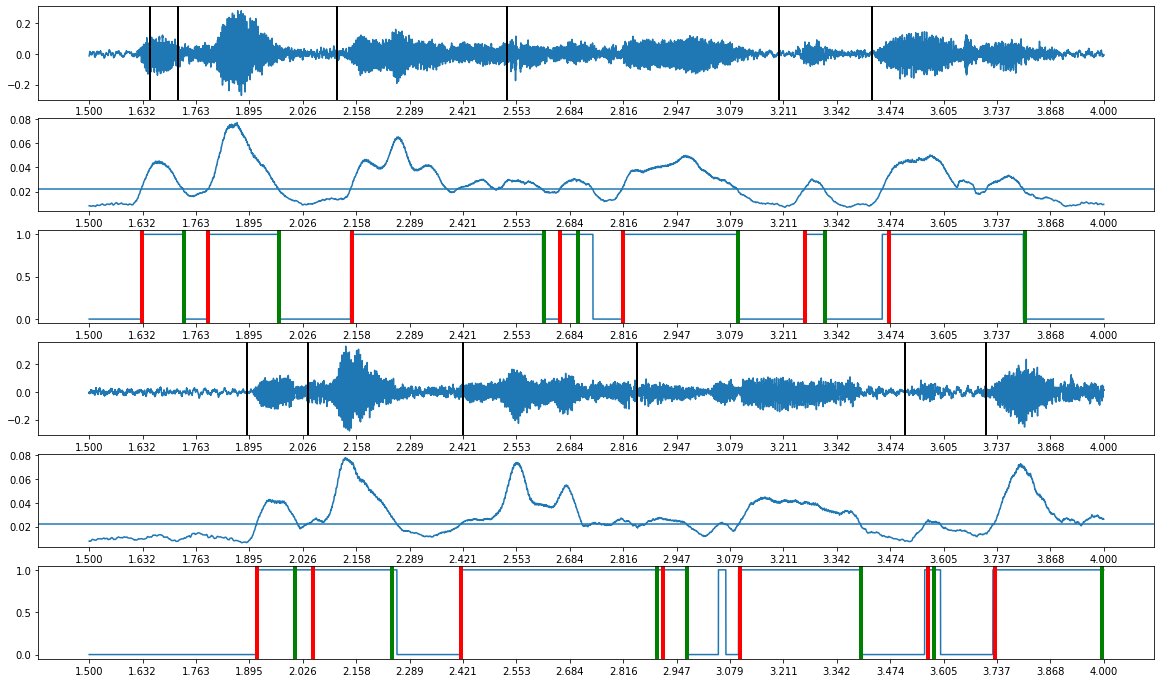

In [69]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-normal2.wav", 1.5, 4

timelst1 = [1.65, 1.72, 2.11, 2.53, 3.2, 3.43]
timelst2 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1=0.022, threshold2=0.022,
      timelst1=timelst1, timelst2 = timelst2, alpha=30)
# unit = ms 

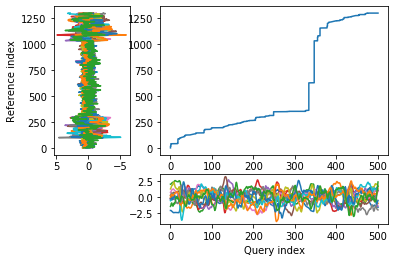

                        1         2         3         4         5        6   \
seg                 speech     pause    speech     pause    speech    pause   
start in voice 1   1.50057   1.50111   1.50129   1.50218   1.50293  1.50467   
start in voice 2   1.50222   1.50286   1.50304   1.50408   1.50454  1.50646   
stretch           0.431084  0.393665  0.471456  0.477052  0.428101  0.49381   

                        7        8         9        10       11  
seg                 speech    pause    speech    pause   speech  
start in voice 1   1.50805  1.50828   1.50896  1.50973  1.51018  
start in voice 2   1.52358  1.52626   1.52773  1.52857    1.529  
stretch           0.496639  0.45862  0.446803  0.36974      0.5  

DTW distance =  2.8250192738344


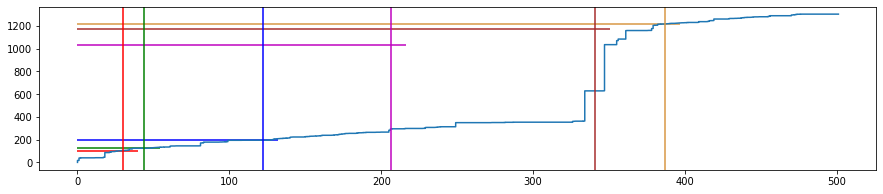

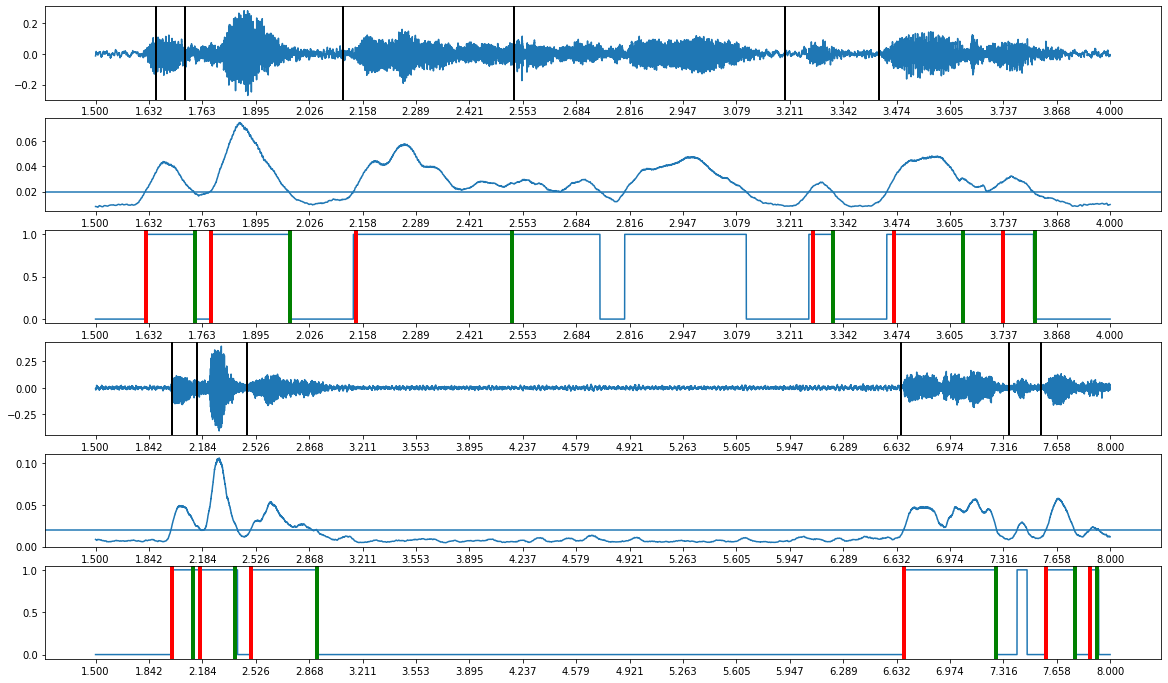

In [95]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-pause1.wav", 1.5, 8

timelst1 = [1.65, 1.72, 2.11, 2.53, 3.2, 3.43]
timelst2 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02, threshold2=0.02,
      timelst1=timelst1, timelst2 = timelst2, alpha = 10)

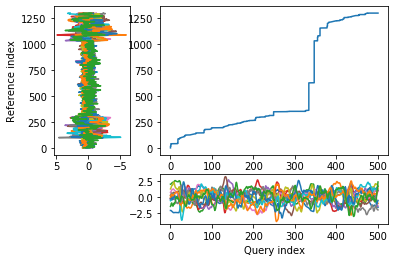

                        1        2         3         4         5         6   \
seg                 speech    pause    speech     pause    speech     pause   
start in voice 1   1.50059  1.50109   1.50132   1.50215   1.50293   1.50467   
start in voice 2   1.50224  1.50286   1.50306   1.50406   1.50454   1.50644   
stretch           0.872656  0.76421  0.927599  0.927123  0.834245  0.987666   

                        7         8         9         10       11  
seg                 speech     pause    speech     pause   speech  
start in voice 1   1.50805   1.50821   1.50896    1.5095  1.51018  
start in voice 2   1.52361   1.52626   1.52773   1.52855    1.529  
stretch           0.992398  0.897614  0.845399  0.805598        1  

DTW distance =  2.8250192738344


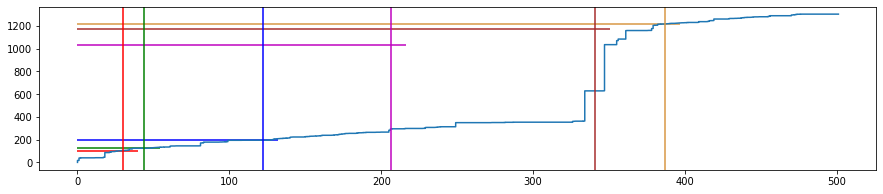

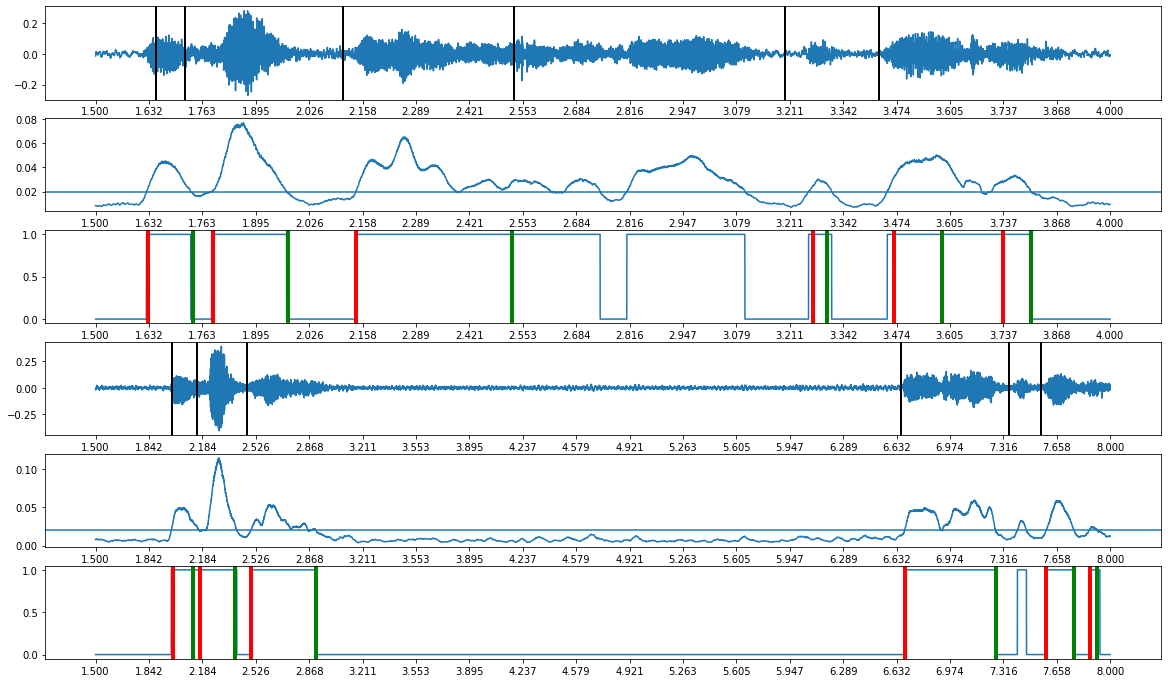

In [74]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-pause1.wav", 1.5, 8

timelst1 = [1.65, 1.72, 2.11, 2.53, 3.2, 3.43]
timelst2 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02, threshold2=0.02,
      timelst1=timelst1, timelst2 = timelst2)

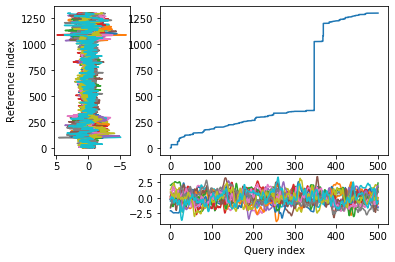

                         1         2         3         4         5         6  \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   1.50059   1.50109   1.50132   1.50215   1.50293   1.50467   
start in voice 2   1.50227   1.50286   1.50327   1.50406    1.5046   1.50646   
stretch           0.796051  0.890313  0.916709  0.856111  0.801415  0.982566   

                         7         8         9  
seg                 speech     pause    speech  
start in voice 1   1.50893   1.50973   1.51011  
start in voice 2   1.52773   1.52857   1.52898  
stretch           0.871672  0.883383  0.885788  

DTW distance =  3.7278139682851927


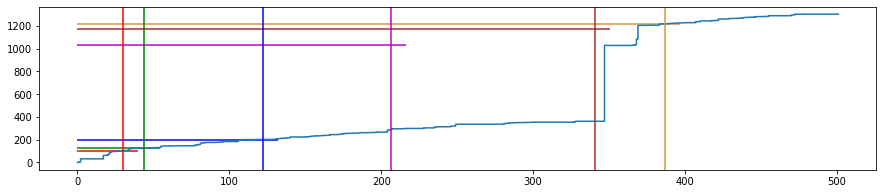

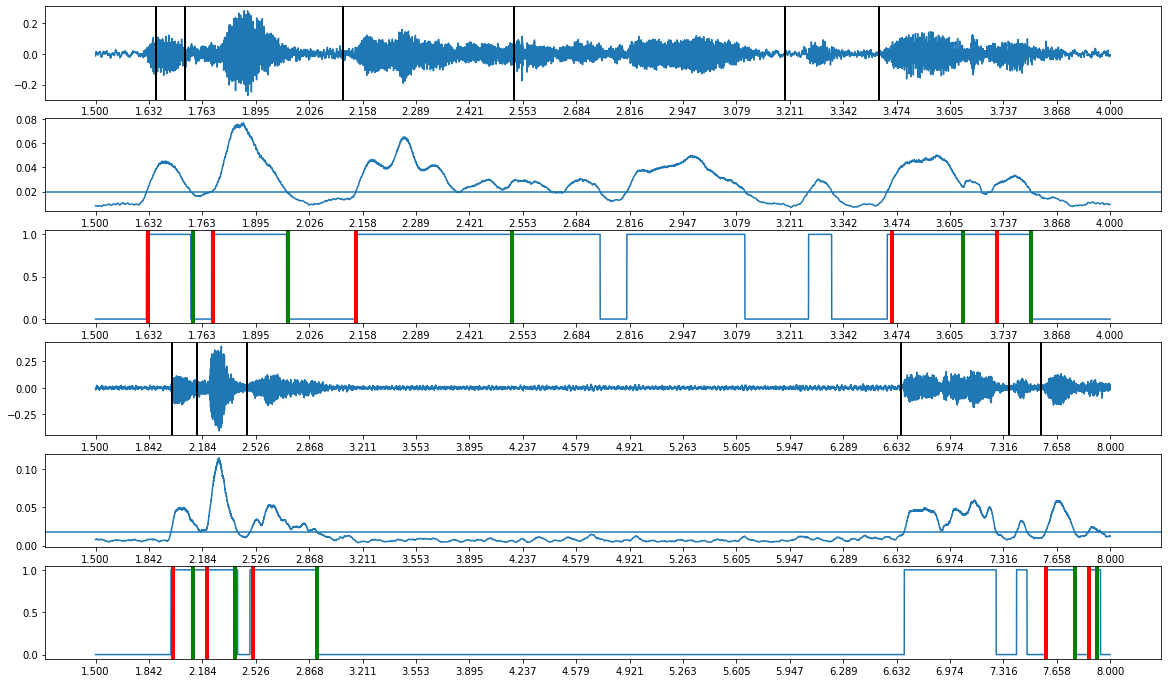

In [80]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-pause1.wav", 1.5, 8

timelst1 = [1.65, 1.72, 2.11, 2.53, 3.2, 3.43]
timelst2 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02, threshold2=0.018,
      timelst1=timelst1, timelst2 = timelst2, num_of_mfcc=20)

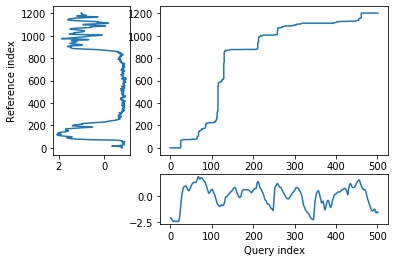

                        1         2         3         4         5         6   \
seg                 speech     pause    speech     pause    speech     pause   
start in voice 1   1.50063   1.50193   1.50331   1.50481   1.50483   1.50483   
start in voice 2   2.00161   2.00408   2.01989   2.02129    2.0215   2.02177   
stretch           0.143507  0.158612  0.158419  0.237693  0.181818  0.181818   

                        7        8         9         10         11        12  \
seg                 speech    pause    speech     pause     speech     pause   
start in voice 1   1.50483  1.50585   1.50585    1.5061    1.50689   1.50721   
start in voice 2   2.02204  2.02299   2.02313   2.02438    2.02494   2.02517   
stretch           0.151186      0.2  0.161106  0.138196  0.0995246  0.157163   

                        13        14       15  
seg                 speech     pause   speech  
start in voice 1   1.51016   1.51045  1.51045  
start in voice 2   2.02567   2.02642  2.02705  
stretc

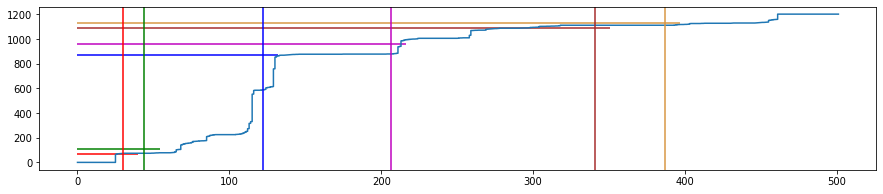

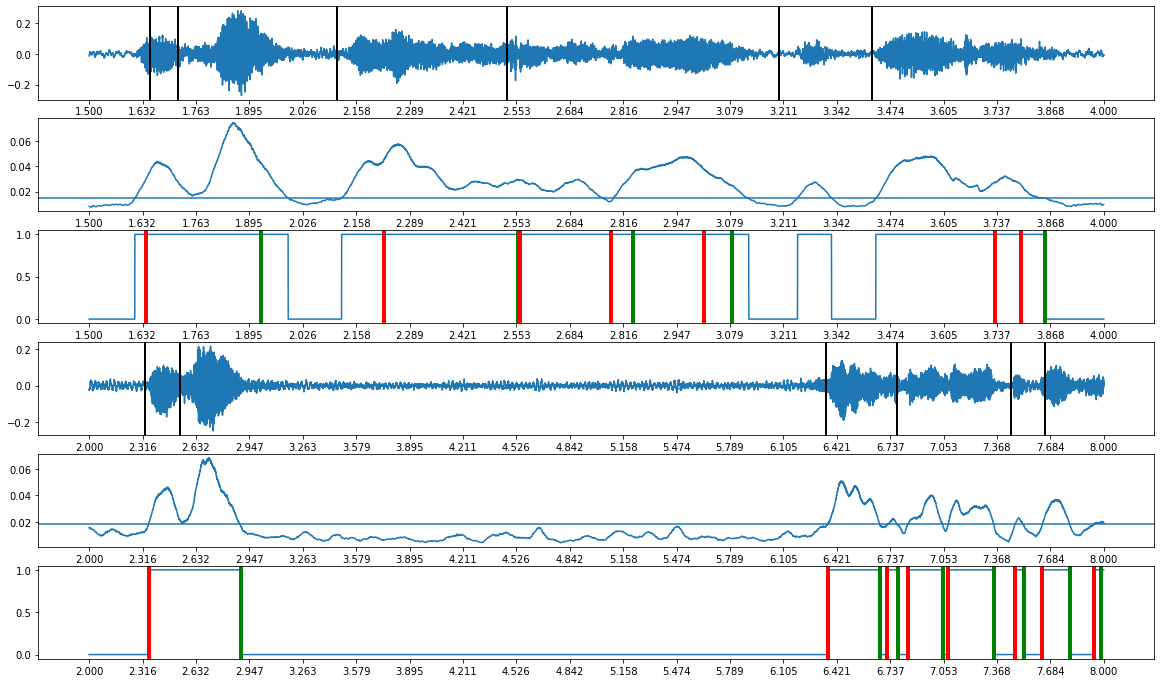

In [91]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-pause2.wav", 2, 8

timelst1 = [1.65, 1.72, 2.11, 2.53, 3.2, 3.43]
timelst2 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.015, threshold2=0.018,
      timelst1=timelst1, timelst2 = timelst2, alpha = 30, num_of_mfcc=1)